In [ ]:
# Install RDKit in Colab
!pip install rdkit-pypi


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 74.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will prompt you to select your SDF file


Saving archive (5).zip to archive (5).zip


In [ ]:
import zipfile

zip_path = '/content/archive (5).zip'  # Path to your uploaded zip file

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')  # Extracts to /content/


In [ ]:
import os

for root, dirs, files in os.walk('/content/'):
    for file in files:
        if file.endswith('.sdf'):
            print(os.path.join(root, file))


/content/tox21.sdf


In [ ]:
from rdkit import Chem
import pandas as pd

sdf_path = '/content/tox21.sdf'  # Update this if the path is different

suppl = Chem.SDMolSupplier(sdf_path)
mols = [mol for mol in suppl if mol is not None]

data = []
for mol in mols:
    props = mol.GetPropsAsDict()
    props['ROMol'] = mol
    data.append(props)

df = pd.DataFrame(data)
print(df.head())


[06:24:33] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[06:24:33] ERROR: Could not sanitize molecule ending on line 21572
[06:24:33] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
[06:24:34] Explicit valence for atom # 2 Si, 8, is greater than permitted
[06:24:34] ERROR: Could not sanitize molecule ending on line 346021
[06:24:34] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
[06:24:34] Explicit valence for atom # 3 Cl, 2, is greater than permitted
[06:24:34] ERROR: Could not sanitize molecule ending on line 446665
[06:24:34] ERROR: Explicit valence for atom # 3 Cl, 2, is greater than permitted
[06:24:34] Explicit valence for atom # 1 Cl, 2, is greater than permitted
[06:24:34] ERROR: Could not sanitize molecule ending on line 619150
[06:24:34] ERROR: Explicit valence for atom # 1 Cl, 2, is greater than permitted
[06:24:34] WARNING: not removing hydrogen atom without neighbors
[06:24:34] Explicit valence for atom # 2 Si,

         Formula                                                 FW  \
0     C27H25ClN6               468.9806 (35.4535+224.2805+209.2465)   
1  C20H6Br4Na2O5                691.8542 (645.8757+22.9892+22.9892)   
2     C47H83NO17                        934.1584 (916.1205+18.0379)   
3    C52H54N4O12  927.0048 (329.4575+89.0275+89.0275+329.4575+90...   
4   C66H87N17O14                      1342.5025 (1282.4505+60.0520)   

   DSSTox_CID  SR-HSE                                             ROMol  \
0     25848.0     0.0  <rdkit.Chem.rdchem.Mol object at 0x7e8e626caf10>   
1      5234.0     0.0  <rdkit.Chem.rdchem.Mol object at 0x7e8e626caea0>   
2     28909.0     0.0  <rdkit.Chem.rdchem.Mol object at 0x7e8e626caf80>   
3      5513.0     1.0  <rdkit.Chem.rdchem.Mol object at 0x7e8e626cb0d0>   
4     26683.0     NaN  <rdkit.Chem.rdchem.Mol object at 0x7e8e626caff0>   

   NR-AR  SR-ARE  NR-Aromatase  NR-ER-LBD  NR-AhR  ...  NR-PPAR-gamma  SR-p53  \
0    NaN     NaN           NaN        NaN

In [ ]:
target_col = 'NR-AR'  # You can change this to any other assay column if you wish


In [ ]:
# Drop rows where target is missing
df = df[df[target_col].notnull()]

# Convert target to integer (assuming it's binary: 0/1 or -1/1)
df[target_col] = df[target_col].astype(int)

# Convert molecules to fingerprints
import numpy as np
from rdkit.Chem import AllChem

def mol_to_fp(mol, radius=2, nBits=2048):
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits))

X = np.stack(df['ROMol'].apply(mol_to_fp))
y = df[target_col].values


/tmp/ipython-input-17-2474173164.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target_col] = df[target_col].astype(int)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []
auc_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    print(f"Fold {fold+1}")
    X_tr, X_val = X_train[train_index], X_train[val_index]
    y_tr, y_val = y_train[train_index], y_train[val_index]

    model = keras.Sequential([
        keras.layers.Input(shape=(X_tr.shape[1],)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    # Class weight to handle imbalance
    class_weight = {0:1, 1:len(y_tr)/sum(y_tr)}

    model.fit(X_tr, y_tr, epochs=15, batch_size=32, verbose=0, class_weight=class_weight)

    y_val_pred = (model.predict(X_val).flatten() > 0.5).astype(int)
    y_val_prob = model.predict(X_val).flatten()

    acc = accuracy_score(y_val, y_val_pred)
    auc = roc_auc_score(y_val, y_val_prob)

    accuracies.append(acc)
    auc_scores.append(auc)

    print(f"Accuracy: {acc:.4f}, ROC-AUC: {auc:.4f}")

print("\nCross-validated accuracy: {:.2f}% (+/- {:.2f}%)".format(np.mean(accuracies)*100, np.std(accuracies)*100))
print("Cross-validated ROC-AUC: {:.2f} (+/- {:.2f})".format(np.mean(auc_scores), np.std(auc_scores)))


Fold 1
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9573, ROC-AUC: 0.7241
Fold 2
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9618, ROC-AUC: 0.8305
Fold 3
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9631, ROC-AUC: 0.7680
Fold 4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.9592, ROC-AUC: 0.7321
Fold 5
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.9546, ROC-AUC: 0.7488

Cross-validated accuracy: 95.92% (+/- 0.30%)
Cross-validated ROC-AUC: 0.76 (+/- 0.04)


In [ ]:
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

class_weight = {0:1, 1:len(y_train)/sum(y_train)}

model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1, class_weight=class_weight)

# Predict and evaluate on test set
y_test_prob = model.predict(X_test).flatten()
y_test_pred = (y_test_prob > 0.5).astype(int)

print("Test set accuracy:", accuracy_score(y_test, y_test_pred))
print("Test set ROC-AUC:", roc_auc_score(y_test, y_test_prob))
print("Classification report:\n", classification_report(y_test, y_test_pred))


Epoch 1/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8625 - auc_5: 0.7062 - loss: 1.2385
Epoch 2/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8638 - auc_5: 0.8554 - loss: 0.8080
Epoch 3/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8997 - auc_5: 0.9614 - loss: 0.5119
Epoch 4/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9538 - auc_5: 0.9846 - loss: 0.2953
Epoch 5/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9656 - auc_5: 0.9907 - loss: 0.1909
Epoch 6/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9689 - auc_5: 0.9949 - loss: 0.1619
Epoch 7/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9776 - auc_5: 0.9961 - loss: 0.1424
Epoch 8/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9759 - auc_5: 0.9964 - loss: 0.1281
Epoch 9/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9796 - auc_5: 0.9971 - loss: 0.1113
Epoch 10/15
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9825 - auc_5: 

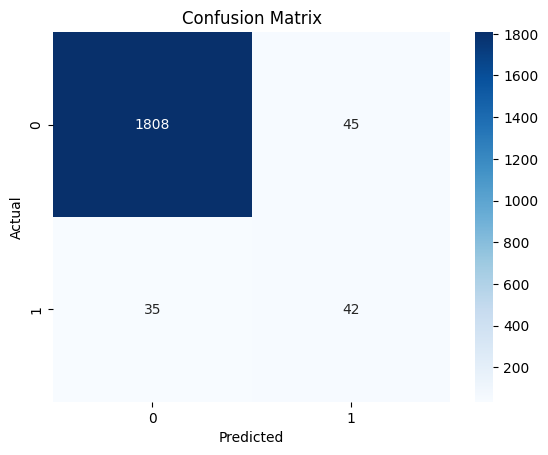

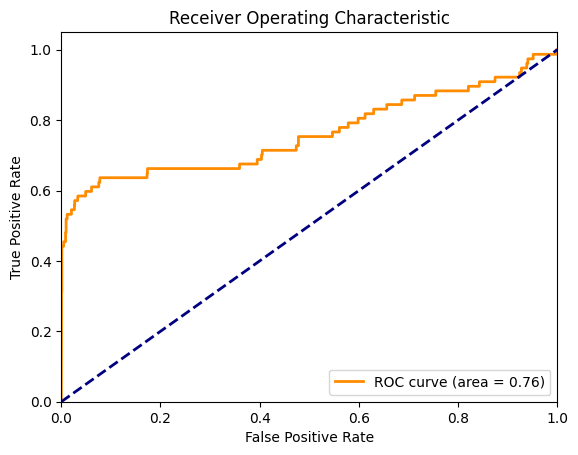

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
